# **数据准备**

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# 数据预处理和加载
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

torch.manual_seed(42)

train_dataset = datasets.ImageFolder(root='/kaggle/input/pothole-detection-dataset/train', transform=transform)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


test_dataset = datasets.ImageFolder(root='/kaggle/input/pothole-detection-dataset/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# **模型定义**

In [2]:
import torch.nn as nn
from torchvision import models

# 定义ResNet50模型
class ResNet50(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet50, self).__init__()
        self.resnet50 = models.resnet50(pretrained=True)
        in_features = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.resnet50(x)


# **初始化模型、损失函数和优化器**

In [3]:
import torch.optim as optim
from torch.optim import lr_scheduler


# 初始化模型、损失函数和优化器
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet50().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 使用学习率调度器
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 225MB/s] 


# **训练模型**

In [4]:
# 训练模型
num_epochs = 100
best_val_loss = float('inf')
best_model = None
train_losses = []  
val_losses = [] 

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    if (epoch + 1) % 10 == 0 or epoch / 10 - 1 <= 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss}')
            
            
    scheduler.step()
    
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    if (epoch + 1) % 10 == 0 or epoch / 10 - 1  <= 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Learning Rate: {optimizer.param_groups[0]["lr"]}, Validation Loss: {val_loss/len(val_loader)}')
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model = model.state_dict()
    





Epoch 1/100, Training Loss: 0.5010266602039337
Epoch 1/100, Learning Rate: 0.0001, Validation Loss: 0.36646672487258913
Epoch 2/100, Training Loss: 0.3428563714027405
Epoch 2/100, Learning Rate: 0.0001, Validation Loss: 0.3562065541744232
Epoch 3/100, Training Loss: 0.3274580553174019
Epoch 3/100, Learning Rate: 0.0001, Validation Loss: 0.34962599277496337
Epoch 4/100, Training Loss: 0.31715531200170516
Epoch 4/100, Learning Rate: 0.0001, Validation Loss: 0.34699363112449644
Epoch 5/100, Training Loss: 0.3180190622806549
Epoch 5/100, Learning Rate: 1e-05, Validation Loss: 0.34076614379882814
Epoch 6/100, Training Loss: 0.3145393118262291
Epoch 6/100, Learning Rate: 1e-05, Validation Loss: 0.33873050212860106
Epoch 7/100, Training Loss: 0.31469313651323316
Epoch 7/100, Learning Rate: 1e-05, Validation Loss: 0.3390676259994507
Epoch 8/100, Training Loss: 0.31391821801662445
Epoch 8/100, Learning Rate: 1e-05, Validation Loss: 0.3387947082519531
Epoch 9/100, Training Loss: 0.31423589140176

# **损失对比图**

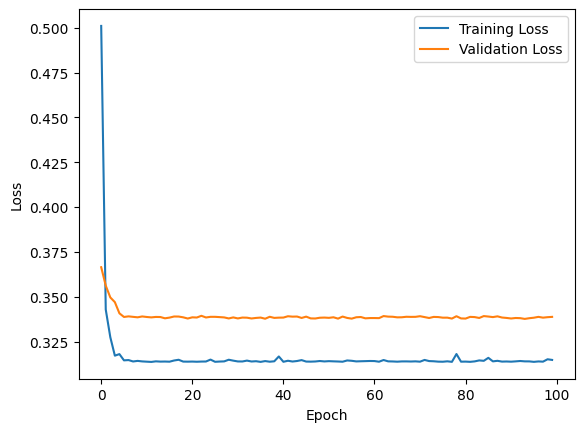

In [5]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **测试集上测试**

Accuracy: 0.9677
Precision: 0.9808
Recall: 0.9623
F1 Score: 0.9714


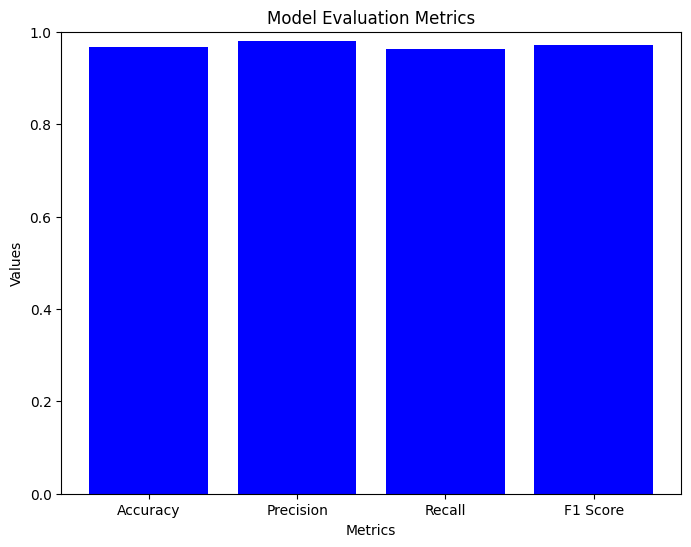

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np


model.load_state_dict(best_model)
model.eval()

all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # 计算模型的预测
        outputs = model(inputs)
        predictions = torch.argmax(outputs, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

# 计算精度、准确度、F1分数和召回率
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

# 输出评估结果
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# 绘制单个直方图
metrics = [accuracy, precision, recall, f1]
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

plt.figure(figsize=(8, 6))
plt.bar(labels, metrics, color='blue')
plt.title('Model Evaluation Metrics')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.ylim(0.0, 1.0)  # 设置y轴范围为0到1
plt.show()

# **图片预测**

In [42]:
#! pip install opencv-python


道路存在威胁！


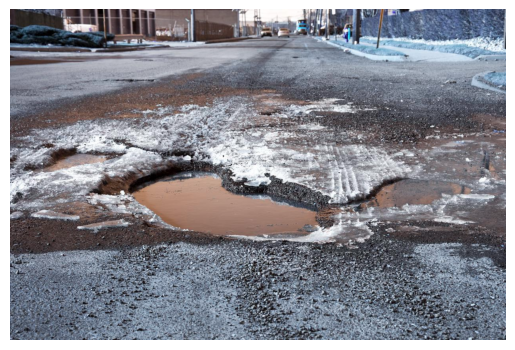

In [47]:
import cv2
import random
import os
from PIL import Image
import torch
from torchvision import transforms

# Assuming transform is your preprocessing transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

images_paths = ['/kaggle/input/pothole-detection-dataset/test/potholes/' + fil for fil in os.listdir('/kaggle/input/pothole-detection-dataset/test/potholes')]
sample_image_path = random.sample(images_paths, 1)[0]

# Read the image using OpenCV
sample_image = cv2.imread(sample_image_path)

if sample_image is not None:
    # Convert OpenCV BGR to RGB
    sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
    
    # Convert NumPy array to PIL
    sample_image_pil = Image.fromarray(sample_image)
    
    # Apply the transformation
    input_tensor = transform(sample_image_pil)
    input_batch = input_tensor.unsqueeze(0).to(device)

    outputs = model(input_batch)
    predictions = torch.argmax(outputs, dim=1)
    if predictions == 0:
        print("道路正常！")
    else:
        print("道路存在威胁！")
        
    '''
        
    cv2.imshow("Sample Image", cv2.cvtColor(sample_image, cv2.COLOR_RGB2BGR))
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    '''
        
    sample_image_rgb = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

    # 显示图像
    plt.imshow(sample_image_rgb)
    plt.axis('off')  
    plt.show()
    
else:
    print(f"Error: Unable to read the image from {sample_image_path}")


# **保存模型**

In [7]:
# 保存模型
torch.save(model.state_dict(), 'resnet50_model.pth')